##In this file I will be applying my matlab fretwheel code for the ipython notebook.

####I haven't defined all the functions I used in Matlab in Python yet so for this exercise I'll go through every step without using too many of my own functions.

In [2]:
import numpy as np#Essential library of math operations (including numpy arrays, ~ matlab matrices)
import matplotlib.pyplot as plt#Essential library for plotting
import tifffile as tif# Importing this with the tifffile.c file results in faster loading (still very fast without it)

tifffile.py:246: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be very slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"


First, I'll need to load my donor, fret, and acceptor files that have a common prefix.

In [3]:
labelEFF= raw_input('Label for written file: ')#Prefix for set of data

#Load image stacks for each channel
donorStack= tif.imread(labelEFF+'Cropbleachdonor.tif')
fretStack= tif.imread(labelEFF+'Cropbleachfret.tif')
acceptorStack= tif.imread(labelEFF+'Cropbleachacceptor.tif')

#Will make the window interactive so that we can use ginput to select points
%matplotlib qt 
plt.imshow(acceptorStack[0], vmin= 0, vmax= 1000)
plt.show()#Equivalent to 'hold on' in Matlab, allows you plot on top of current figure

Label for written file: cell7


In [4]:
#Select background area from image
coords= plt.ginput()

c:\Users\D\Anaconda\lib\site-packages\matplotlib\backend_bases.py:2399: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


In [5]:
#Round coordinates
x= round(coords[0][0])
y= round(coords[0][1])
print x,y

294.0 204.0


In [22]:
#Below are optional lines to check that you selected correct location (plots the position of your center/window).
# plt.plot(x,y,'o',color= 'white')
# plt.plot(x-10,y-10,'ro', color= 'red')
# plt.plot(x+10,y+10,'ro', color= 'red')
# plt.plot(x-10,y+10,'ro', color= 'red')
# plt.plot(x+10,y-10,'ro', color= 'red')

#Use first image for each channel to measure background at those coordinates
donor0= donorStack[0]
fret0= fretStack[0]
acceptor0= acceptorStack[0]

In [7]:
#Now we'll take the average background from each channel in 21x21 window
#Make sure to list submatrix as [yStart:yEnd,xStart:xEnd] cause its [rows,cols]
#Note: mean() without np. should work but it's been giving me errors
donorBack= np.mean(donor0[y-10:y+10,x-10:x+10])
fretBack= np.mean(fret0[y-10:y+10,x-10:x+10])
acceptorBack= np.mean(acceptor0[y-10:y+10,x-10:x+10])

print donorBack, fretBack, acceptorBack#Doublecheck values are reasonable


119.595 143.19 115.0475


In [23]:
#Now we'll define bleed-through values (characteristic for your scope, collected previously)
btdonor= 0.6072;#40x air updated 1/21/15
btacceptor= 0.0437

###Now we'll load all raw images for each timepoint, background subtract, bleed-through correct, calculate FRET efficiency, clean up image and write files to the directory.

In [9]:
import time
from tifffile import imsave

t0 = time.time()
for i in range(0,len(acceptorStack)):#Loop through image stack for each channel
    donor= donorStack[i]
    fret= fretStack[i]
    acceptor= acceptorStack[i]
    
    donor= donor-donorBack#Background subtraction
    fret= fret-fretBack
    acceptor= acceptor-acceptorBack
    
    #Convert datatypes to doubles so we can get decimals from division
    donor= np.double(donor); fret= np.double(fret); acceptor= np.double(acceptor);
    fretcorrected= fret - donor*(btdonor) - acceptor*(btacceptor)#Bleedthrough correction for donor and acceptor channels.
    
    #Note: In an earlier version of the script I could just write donor[donor<0] = nan but now it says 'nan' is not defined...so:
    donor[donor<0]= float('nan')#Threshold negative values 
    fret[fret<=0]= float('nan')
    acceptor[acceptor<=0]= float('nan')
    
    #Below we calculate FRET efficiency and threshold values by using the acceptor channel image as a reference
    efficiency= 100*(fretcorrected/(fretcorrected+donor));
    acceptorMask= acceptor>100#Threshold, results in boolean matrix
    maskEff= efficiency*acceptorMask#Anything 
    #maskEff[acceptorMask]= float('nan')#At acceptorMask indices where intensity<threshold, turn to nan
    
    #This part of the code in Matlab assembled a structure with all parameters
    maskEff2= np.uint16(maskEff)#Convert data back into uint16 format to write a uint16 file
    imsave('python_writeRedo2'+str(i)+'.tif',maskEff2)
    
t1= time.time()
total= t1-t0
print 'Time to calculate and write files: ', total

Time to calculate and write files:  5.56299996376


c:\Users\D\Anaconda\lib\site-packages\IPython\kernel\__main__.py:25: RuntimeWarning: invalid value encountered in greater


###### Check the directory, the although tifffile module couldn't write files to a stack, all the timepoints are there. The values are reasonable and match the Matlab output pretty well. In addition, this last for loop took us ~4-6 s to run whereas it took Matlab about 20s (after stripping .m file to make it comparable in tasks). 

###It looks like fretwheel.py is a faster version of fretwheel.m .

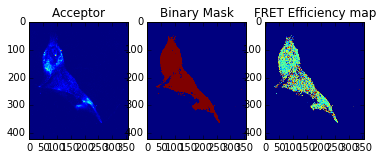

In [21]:
#Here are sample images of the last timepoint of acceptor channel image vs mask vs fret efficiency image

%matplotlib inline
plt.subplot(1,3,1)
plt.imshow(np.uint16(acceptor))

plt.title('Acceptor ')


plt.subplot(1,3,2)
plt.imshow(acceptorMask)
plt.title('Binary Mask')

plt.subplot(1,3,3)
plt.imshow(maskEff2, vmin= 0, vmax= 75)
plt.title('FRET Efficiency map')

